# Manutenção Preditiva de Caso: Paper CO - Modelagem

### Bibliotecas

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('D:/Projetos/outros/suzano/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## modelo
from sklearn import preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate, cross_val_predict

# check xgboost version
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

### Funções

In [ ]:
# procura pro dados nan
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

***
## 1) Definição do problema e objetivo do projeto

A Paper CO é um importante player que produz principalmente celulose fornecendo este importante material para os fabricantes de papel e para suas próprias máquinas de papel.
 
O mercado está cada vez mais desafiador devido à queda dos preços internacionais da celulose.


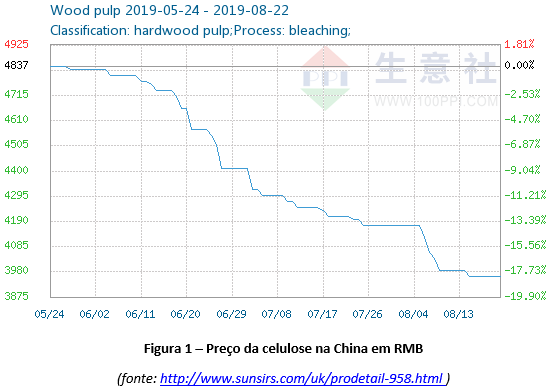

Devido ao cenário desafiador, a Paper Co está iniciando um projeto para redução de custos em manutenção evitando a manutenção excessiva de alguns ativos específicos e mantendo a mesma disponibilidade de todo o processo. 

Para isso, será necessário prever falhas nos ativos selecionados.
O chefe das operações perguntou se é possível prever tais eventos e com base em suas respostas ele mudará os planos de manutenção.


***
### Objetivo

Apresentar descobertas e fornecer recomendações sobre a alteração dos planos de manutenção.

***
### Entendimento do desafio

- plano de manutenção é feito com frequência fixa por tempo de calendário. (apresentar um gráfico freq x tempo)

- A primeira fase é verificar a viabilidade de um RUL (vida útil restante) e/ou um modelo para prever a falha com pelo menos 20 ciclos de antecedência
    - Para **treinar** o modelo, você receberá um conjunto de dados com informações de 100 eventos de falhas nesses ativos. Consulte a Tabela 1 com as informações disponíveis. 
    - Na **reunião** também é necessário demonstrar seu entendimento do problema e mostrar algumas estatísticas dos ativos para ilustrar o problema e a solução proposta.

- Usando o modelo treinado, você deve pontuar para cada ID de ativo nos dados de **teste**, fornecendo as informações se o ativo falhará após mais 20 ciclos (probabilidade 0-1) ou (de preferência) quantos ciclos restantes o ativo ainda possui (RUL). Você enviará a saída do arquivo de teste que deve conter uma única coluna e uma linha para cada ativo (100 no total) fornecendo as informações acima.

- Sua previsão será pontuada usando KPIs de qualidade para algoritmos de aprendizado de máquina, **esteja preparado** para comentar os KPIs durante a entrevista. Você pode simular cenários para demonstrar o desempenho do modelo em relação a um processo ingênuo de alteração do ativo em um período fixo.

- Por fim, você terá que responder como a equipe de manutenção usará seu modelo para reduzir custos.

***
### 1.1) Dicionario de dados

### Conjunto de dados com informações de falhas para cada id de ativo

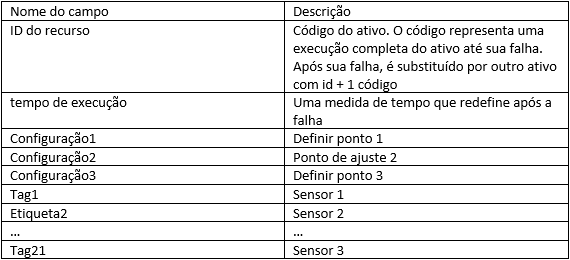

***
## 2) Coleta e preparação dos dados

### 2.1) Coleta dos dados - Modelagem

In [ ]:
colunas = ['id_recurso', 'tmp_exe', 'cfg1', 'cfg2', 'cfg3', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5', 
           'tag6', 'tag7', 'tag8', 'tag9', 'tag10', 'tag11', 'tag12', 'tag13', 'tag14', 'tag15', 'tag16', 'tag17', 'tag18', 'tag19', 'tag20', 'tag21']

In [ ]:
df = pd.read_csv('./dataset/PM_train.txt', delimiter=" ", header=None).drop([26, 27], axis=1)
df.columns = colunas

df

### Checar dados faltantes

In [ ]:
just_check_nan(df)

### Checagem e mudança de Tipagem

In [ ]:
df.info()

## 2.2) Preparação dos dados

### Seleção de Features

In [ ]:
df.columns

### Feature Importance - Criado em outro notebook

In [ ]:
# X = df_dropped.drop(['VALOR'], axis=1)

X = df_dropped[['IDADE', 'IMC', 'FILHOS', 'FUMANTE']]

X

### Seleção do Target

In [ ]:
# define target
y = df_dropped['VALOR']

### Variaveis Categoricas

In [ ]:
# Criando uma lista de variaveis categoricas
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

### Variaveis Numéricas

In [ ]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

***
# 3) Modelagem dos dados

## 3.1) Dividindo as features em dados de treino e validação

In [ ]:
# Dividindo as features em dados de treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.7, 
                                                  random_state = 2048)

## 3.2) Pipeline 

### Pré-processamento para Dados Numéricos

StandardScaler resulta em uma distribuição com desvio padrão igual a 1. A variância também é igual a 1, porque variância = desvio padrão ao quadrado. E 1 ao quadrado = 1.

StandardScaler torna a média da distribuição 0. Cerca de 68% dos valores estarão entre -1 e 1.

Os algoritmos de aprendizado profundo geralmente exigem média zero e variação de unidade. Algoritmos do tipo regressão também se beneficiam de dados normalmente distribuídos com tamanhos de amostra pequenos.

In [ ]:
# Pré-processamento para Dados Numéricos
numerical_transformer = Pipeline([
                                  ('scaler', StandardScaler())
                                 ])

### Pré-processamento para Dados Categóricos

In [ ]:
# Pré-processamento para Dados Categóricos
categorical_transformer = Pipeline([
                                    ('onehot', OneHotEncoder())
                                   ])

### Pré-processamento de pacote de dados numéricos e categóricos

In [ ]:
# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor = ColumnTransformer(transformers=[
                                                ('num', numerical_transformer, numerical_cols),
                                                ('cat', categorical_transformer, object_cols)
                                              ], n_jobs=-1)

### Pipeline

In [ ]:
pipeline = Pipeline(steps=[
                            ('preprocessor', preprocessor),
                            ('imputation', KNNImputer()),
                            ('model', GradientBoostingRegressor(random_state=2048))
                          ])

### Fit

In [ ]:
# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

### Cross Validation

In [ ]:
scores = cross_validate(pipeline, X, y, cv=5, n_jobs=-1,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'))
# scores

In [ ]:
print(scores['test_r2'])

In [ ]:
print(scores['test_neg_mean_squared_error'])

In [ ]:
print(scores['test_neg_mean_absolute_error'])

### Previsão

In [ ]:
preds = pipeline.predict(X_val)
# preds

***
# 4) Avaliação do modelo

## 4.1) Métricas

### R2 Score - o coeficiente de determinação

Representa a proporção da variância de y. 

A melhor pontuação possível é 1,0 e pode ser negativa

In [ ]:
# l1 = [2, 40, 600, 900]
# l2 = [30, 90, 733, 993]
# print('r2', r2_score(l1, l2))
# print('mean_absolute_error', mean_absolute_error(l1, l2))
# print('mean_squared_error', mean_squared_error(l1, l2))

In [ ]:
r2_score(y_val, preds)

### Erro médio absoluto (MAE)

Calcula a média dos erros do modelo em valores absolutos, ou seja, a diferença entre o valor real e o previsto, porém é sensível a outliers.

A melhor pontuação possível é 0

In [ ]:
mean_absolute_error(y_val, preds)

### Erro médio quadrado (MSE)

Calcula a média dos erros do modelo ao quadrado.

A melhor pontuação possível é 0

In [ ]:
mean_squared_error(y_val, preds)

## 4.2) Avaliação do modelo com a base de teste - representa 9,49% do total

In [ ]:
df_test = pd.read_excel('/kaggle/input/datasetn/Seguro Sade - Teste Final.xlsx', sheet_name='Gabarito')
df_test

### Checar dados faltantes

In [ ]:
just_check_nan(df_test)

### Apagando dados faltantes

No caso deste problema, como a quantidade de dados faltantes é pouco com relação ao total, optei por deletar os faltantes.

O ideal é averiguar o motivo dos dados faltantes, e se mesmo assim persistir a falta, podemos:

   - Fill nos dados faltantes com:
       - Valores fixos
       - Valores medios
       - Previsão

In [ ]:
df_test_dropped = df_test.dropna().reset_index(drop=True)

### Checando novamente dados faltantes

In [ ]:
just_check_nan(df_test_dropped)

### Definindo X_test

In [ ]:
X_test = df_test_dropped.drop(['VALOR'], axis=1)

X_test

### Definindo y_test

In [ ]:
# define target
y_test = df_test_dropped['VALOR']
y_test

### Previsão

In [ ]:
preds_test = pipeline.predict(X_test)

## 4.3) Metricas

### R2 Score - o coeficiente de determinação

Representa a proporção da variância de y. A melhor pontuação possível é 1,0 e pode ser negativa

In [ ]:
r2_score(y_test, preds_test)

### Erro médio absoluto (MAE)

Calcula a média dos erros do modelo em valores absolutos, ou seja, a diferença entre o valor real e o previsto, porém é sensível a outliers

In [ ]:
mean_absolute_error(y_test, preds_test)

### Erro médio quadrado (MSE)

Calcula a média dos erros do modelo ao quadrado


In [ ]:
mean_squared_error(y_test, preds_test)